In [18]:
# -------- Autogenerated code --------
# modifications to this cell will be overwritten
# Import CSV data into a pandas data frame: 
# see also: http://pandas.pydata.org/
import pandas
small = None
with open('wonambi-inputs/small.csv', 'r') as csv_input:
    small = pandas.read_csv(csv_input, error_bad_lines=False)

In [19]:
%matplotlib inline
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy
import pandas
import sys
import time

# Data presentation change

y_axis = 'time'

# Testings

# See: https://docs.python.org/3/library/time.html#time.strftime
time_format = "%d/%m/%Y %H:%M" # 6/08/2015 9:18

class KnownHeading:
    def __init__(self, name, aliases = [], required = False):
        self.name = name
        self.aliases = aliases
        self.required = required
        self.is_discovered = False

    def __str__(self):
        return "KnownHeading: " + self.name + ". " + ("Required" if self.required else "Not required") + ". Aliases: " + str(self.aliases)

known_headings = [
        KnownHeading('time', ['Time (s)'], required = True),
        KnownHeading('depth', ['Depth (m)', 'Depth(m)', 'Depth_m']),
        KnownHeading('timeb'),
        KnownHeading('axial', ['Surface axial force (kN)']),
        KnownHeading('torque', ['Surface torque (Nm)']),
        KnownHeading('water_pressure', ['Water pressure (bar)']),
        KnownHeading('water_flow_rate', ['Water flow rate (ltr/min)']),
        KnownHeading('rpm'),
        KnownHeading('feed_rate', ['Feed rate (mm/min)']),
        KnownHeading('ph'),
        KnownHeading('ph_mv'),
        KnownHeading('temp', ['Temperature']),
        KnownHeading('temp_mv'),
        KnownHeading('orp'),
        KnownHeading('orp_corrected'),
        KnownHeading('cond', ['Conductivity_uS']),
        KnownHeading('cond_ppt'),
        KnownHeading('cl', ['Cl_ppm']),
        KnownHeading('cl_mv'),
        KnownHeading('ca', ['Ca_ppm']),
        KnownHeading('ca_mv'),
        KnownHeading('k', ['K_ppm']),
        KnownHeading('k_mv'),
        KnownHeading('nh4', ['NH4_ppm']),
        KnownHeading('nh4_mv'),
        KnownHeading('f', ['F_ppm']),
        KnownHeading('f_mv'),
        KnownHeading('no3', ['No3_ppm']),
        KnownHeading('no3_mv'),
        KnownHeading('s'),
        KnownHeading('s_mv'),
        KnownHeading('br', ['Br_ppm']),
        KnownHeading('br_mv')]

y_label = None
for known_heading in known_headings:
    if known_heading.name == y_axis:
        # Use the first alias, if present, as the label, otherwise just use the key:
        y_label = y_axis if len(known_heading.aliases) == 0 else known_heading.aliases[0]
        break

headings = {}
rows = []


data = small
data_row = numpy.asarray(data.keys())

# The headings in the sheet are known as 'discovered' headings.
for cell_number in range(len(data_row)):
    cell = data_row[cell_number]

    # This skips blank headings:
    if cell == '':
        continue

    # Look for the discovered_heading in the known_headings list:
    discovered_heading_name = cell.lower()
    for known_heading in known_headings:
        # When we get a match we add the known_heading object to the headings dictionary, using the cell_number as its key.
        if known_heading.name == discovered_heading_name or discovered_heading_name in (alias.lower() for alias in known_heading.aliases):
            headings[cell_number] = known_heading
            known_heading.is_discovered = True
            break

# Make sure that all the required headings have been discovered:
error = False
for known_heading in known_headings:
    if known_heading.required and not known_heading.is_discovered:
        error = True
        acceptible_aliases_string = ''
        if known_heading.aliases:
            acceptible_aliases_string = " Acceptible aliases are: " + str(known_heading.aliases)[1:-1] + "."

        print("Error: required heading '" + known_heading.name + "' is missing." + acceptible_aliases_string)

if error:
    sys.exit(-1)

    # Now load the non-heading rows:
for row_number, data_row in data.iterrows():
    row = {}
    for key in headings:
        heading = headings[key]
        row[heading.name] = data_row[key]

    rows.append(row)
    
if y_axis == 'time':
    # Process time data:
    # If the time column is being used to plot we need to convert the values to a meaningful format.
    # This section converts the times to seconds since epoch and then subtracts the min time from all cells.
    # That means times will always range from 0 to max.
    min_time = float("inf")
    for row in rows:
        row['time'] = int(time.mktime(datetime.strptime(row['time'], time_format).timetuple()))
        min_time = min(min_time, row['time'])
    
    for row in rows:
        row['time'] -= min_time

# Get the average of a given column. Results are cached so subsequent calls are faster.
_averages = {}
def average(rows, column_name):
    if column_name in _averages:
        return _averages[column_name]

    running_total = 0
    for row in rows:
        running_total += row[column_name]

    _averages[column_name] = running_total / len(rows)
    return _averages[column_name]

def calculate_ignore_div0(calculation):
    try:
        return calculation()
    except ZeroDivisionError:
        return 'DIV0'

# Process the data:------------------------
for row in rows:
    row['cond_cl'] = calculate_ignore_div0(lambda: (row['cond'] / average(rows, 'cond')) / (row['cl'] / average(rows, 'cl')))
    row['br_cl'] = calculate_ignore_div0(lambda: (row['br_mv'] / average(rows, 'br_mv')) / (row['cl_mv'] / average(rows, 'cl_mv')))
    row['br_cond'] = calculate_ignore_div0(lambda: (row['br'] / average(rows, 'br')) / (row['cond'] / average(rows, 'cond')))
    row['nh4_k'] = calculate_ignore_div0(lambda: (row['nh4_mv'] / average(rows, 'nh4_mv')) / (row['k_mv'] / average(rows, 'k_mv')))
    row['nh4_s2'] = calculate_ignore_div0(lambda: (row['nh4_mv'] / average(rows, 'nh4_mv')) / abs(row['s_mv'] / average(rows, 's_mv')))
    row['br_s2'] = calculate_ignore_div0(lambda: (row['br_mv'] / average(rows, 'br_mv')) / abs(row['s_mv'] / average(rows, 's_mv')))

df = pandas.DataFrame(rows)

# TODO: in the Excel spreadsheet the graphs also uses Ca (Query1!$U$1) in the first argument of the series... I'm not sure why.

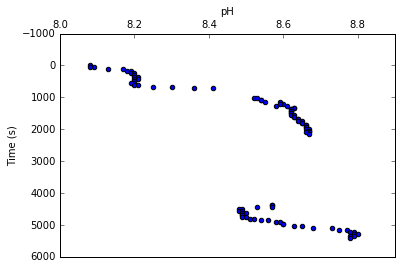

In [20]:
# ph scatter plot:
plt.scatter(df['ph'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('pH')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

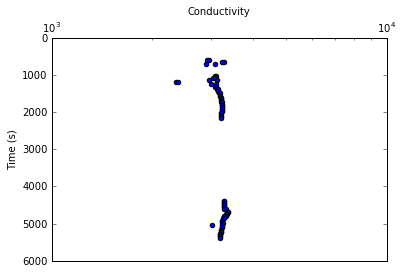

In [21]:
# Conductivity scatter plot (logarithmic X-axis)
plt.scatter(df['cond'], df[y_axis])
axes = plt.gca()

axes.set_xscale('log')
axes.set_xlabel('Conductivity')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

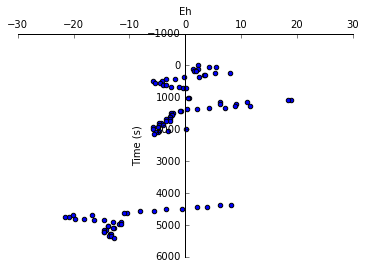

In [22]:
# Eh scatter plot (centered Y-axis)
plt.scatter(df['orp_corrected'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('Eh')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

axes.spines['left'].set_position('zero')
axes.spines['right'].set_color('none')
axes.spines['bottom'].set_color('none')
axes.yaxis.set_ticks_position('left')

plt.show()

In [ ]:
# Ca scatter plot:
plt.scatter(df['ca'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('Ca')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

In [ ]:
# K scatter plot (Logarithmic X-axis):
plt.scatter(df['k'], df[y_axis])
axes = plt.gca()

axes.set_xscale('log')
axes.set_xlabel('K')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

In [ ]:
# NH4 scatter plot:
plt.scatter(df['nh4'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('NH4')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

In [ ]:
# F scatter plot:
plt.scatter(df['f'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('F')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

In [ ]:
# NO3 scatter plot:
plt.scatter(df['no3'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('NO3')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

In [ ]:
# S mV scatter plot (right-aligned Y-axis):
plt.scatter(df['s_mv'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('S mV')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.yaxis.set_ticks_position('right')
axes.yaxis.set_label_position('right')

axes.invert_yaxis()

plt.show()

In [ ]:
# Br scatter plot:
plt.scatter(df['br'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('Br')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

In [ ]:
# Br/Cl scatter plot (centered Y-axis):

# Remove any rows that have DIV0 as a value for br_cl:
df_filtered = df[df.br_cl != 'DIV0']

plt.scatter(df_filtered['br_cl'], df_filtered[y_axis])
axes = plt.gca()

axes.set_xlabel('Br/Cl')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

axes.spines['left'].set_position('zero')
axes.spines['right'].set_color('none')
axes.spines['bottom'].set_color('none')
axes.yaxis.set_ticks_position('left')

plt.show()

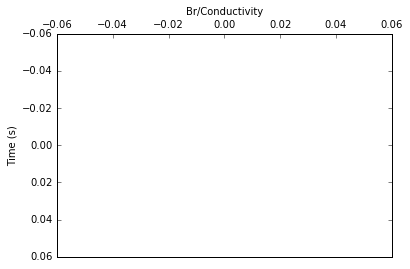

In [13]:
# Br/Conductivity scatter plot:
plt.scatter(df['br_cond'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('Br/Conductivity')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

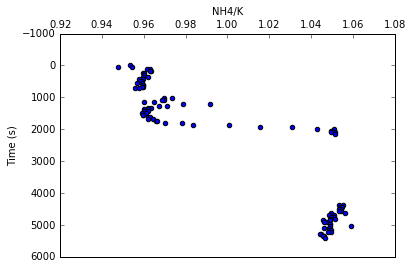

In [63]:
# NH4/K scatter plot:
plt.scatter(df['nh4_k'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('NH4/K')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

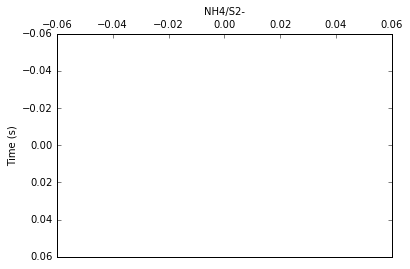

In [64]:
# NH4/S2- scatter plot:
plt.scatter(df['nh4_s2'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('NH4/S2-')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

plt.show()

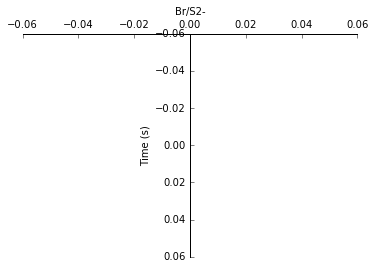

In [65]:
# Br/S2- scatter plot (centered Y-axis):
plt.scatter(df['br_s2'], df[y_axis])
axes = plt.gca()

axes.set_xlabel('Br/S2-')
axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')

axes.set_ylabel(y_label)
axes.invert_yaxis()

axes.spines['left'].set_position('zero')
axes.spines['right'].set_color('none')
axes.spines['bottom'].set_color('none')
axes.yaxis.set_ticks_position('left')

plt.show()